In [1]:
from pathlib import Path
import pyart
import numpy as np



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

from prepro.nexrad import prune_nexrad
from cappi.make_vv import  get_indexed_vv
from mcit.vil import get_vil_from_azran

#viewable plots
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_obj_cmap
from config import _EXAMPLEDATA_DIR

print(_EXAMPLEDATA_DIR)

F:\BOKU\CIWRO\hotspots\exampledata


In [4]:
filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KTLX20230227_012550_V06")
filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KOAX20140603_213649_V06.gz")
#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KEWX20210504_020040_V06")
#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KSHV20230613_230228_V06")

#read in the Level 2 WSR-88D data as a pyart object
radar_vol = pyart.io.read_nexrad_archive(filename)


In [5]:
#remove extra sweeps of data. Keep only data
#from the survelience cuts and one cut per volume 
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)



In [6]:
#create an indexed version of the data on 360 radials
#to a range of 1200 (defaults) at 250m gates.
#We also change formats here to an xarray datastore
#working with xarrys is easier for us than pyart objects
ds = get_indexed_vv(prune_vol, fields=['reflectivity'])


INFO: 1 of 14 current_elev: 0.48
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 2 of 14 current_elev: 0.88
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 3 of 14 current_elev: 1.32
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 4 of 14 current_elev: 1.80
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 5 of 14 current_elev: 2.42
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 6 of 14 current_elev: 3.12
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 7 of 14 current_elev: 4.00
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 8 of 14 current_elev: 5.10
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 9 of 14 current_elev: 6.42
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 10 of 14 current_elev: 8.00
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 11 of 14 current_elev: 10.02
INFO: num_sweeps: 14, num_azs: 360, num_gates: 1200
INFO: 12 of 14 current_elev: 12.48
INFO: num_sweeps: 14, num_a

In [7]:
#compute VIL from the indexed volume of reflectivity
vil = get_vil_from_azran(ds['reflectivity'])
vil.attrs.update(ds.attrs)
#this adds the vil to the xarray dataset we are building


In [8]:
#
#convert the AzRan image to XY coordinates
#
from cappi.xy_cappi import azran_to_xy

x_trg = np.arange(-300, 301)
y_trg = np.arange(-300, 301)

vil_xy = azran_to_xy(vil, x_trg, y_trg)


In [9]:
from mcit.mcit_objects import mcit_objects, mcit_trim

In [10]:
print(vil_xy)

<xarray.DataArray 'VIL' (y: 601, x: 601)> Size: 3MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.11398528,        nan,
               nan]])
Coordinates:
  * x        (x) int32 2kB -300 -299 -298 -297 -296 -295 ... 296 297 298 299 300
  * y        (y) int32 2kB -300 -299 -298 -297 -296 -295 ... 296 297 298 299 300
    lon      (x) float64 5kB -96.37 -96.37 -96.37 ... -96.36 -96.36 -96.36
    lat      (y) float64 5kB 41.32 41.32 41.32 41.32 ... 41.32 41.32 41.32 41.32
Attributes:
    radar_name:       KOAX
 

In [11]:
mcit_raw = mcit_objects(vil_xy, 2.0, 1.25)
mcit_trimmed = mcit_trim(mcit_raw, vil_xy, 5, 50)


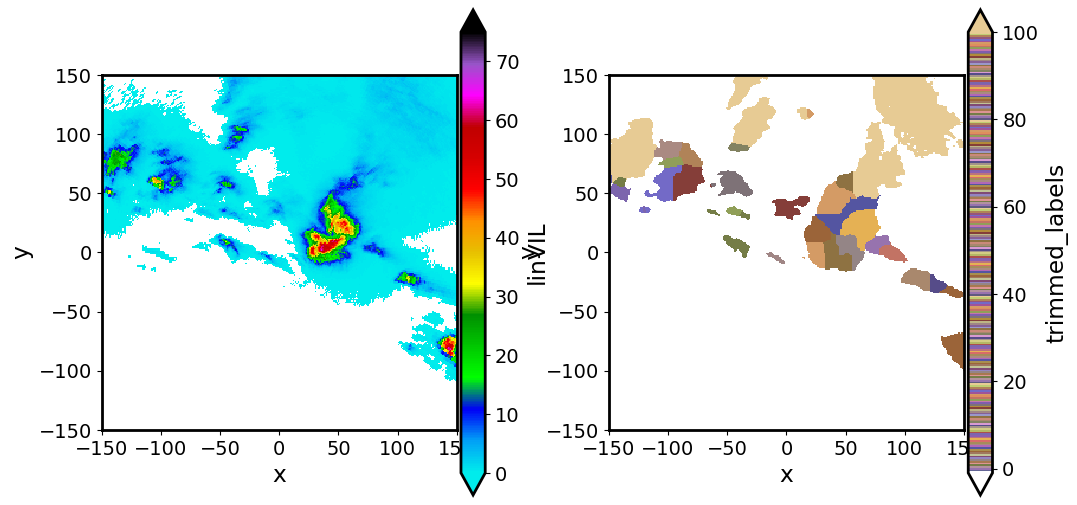

In [12]:
#plot some results
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-150, 150]
ylim = [-150, 150]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025

fig = plt.figure(figsize=(12, 7))
object_cmap = get_obj_cmap()


ax1 = fig.add_subplot(121)
ax1.set_aspect('equal')
ax1.set_ylabel('')


vil_xy.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'linVIL', 'shrink':0.9}
                                           )
ax1.set_title("")


ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_ylabel('')
mcit_trimmed.plot(ax=ax2, x='x', y='y',
                                           vmin=-1.0, vmax=100.0,
                                           xlim=xlim, ylim=ylim,
                                           cmap=object_cmap,
                                             add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'trimmed_labels', 'shrink':0.9}
                                           )
plt.show()

#out_filename = Path("./test.png")
#fig.savefig(out_filename)
plt.close(fig)

In [13]:
print(vil_xy)

<xarray.DataArray 'VIL' (y: 601, x: 601)> Size: 3MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.11398528,        nan,
               nan]])
Coordinates:
  * x        (x) int32 2kB -300 -299 -298 -297 -296 -295 ... 296 297 298 299 300
  * y        (y) int32 2kB -300 -299 -298 -297 -296 -295 ... 296 297 298 299 300
    lon      (x) float64 5kB -96.37 -96.37 -96.37 ... -96.36 -96.36 -96.36
    lat      (y) float64 5kB 41.32 41.32 41.32 41.32 ... 41.32 41.32 41.32 41.32
Attributes:
    radar_name:       KOAX
 

In [14]:
from stormcell.stormcell_helpers import create_stormcell_list

object_list = create_stormcell_list(mcit_trimmed, vil_xy)

In [15]:
from stormcell.stormcell_helpers import print_stormcell_list

print_stormcell_list(object_list)

2 size: 990 max: 42.400808 loc: 214,465
4 size: 676 max: 66.050398 loc: 218,445
10 size: 145 max: 9.454300 loc: 275,423
11 size: 330 max: 34.783359 loc: 278,408
12 size: 465 max: 65.043571 loc: 302,336
13 size: 57 max: 10.007899 loc: 297,289
16 size: 223 max: 15.979349 loc: 301,385
17 size: 354 max: 54.553884 loc: 303,328
20 size: 211 max: 14.305139 loc: 305,377
21 size: 277 max: 33.494987 loc: 309,255
22 size: 381 max: 62.658294 loc: 310,346
24 size: 365 max: 52.003785 loc: 313,333
25 size: 583 max: 47.823855 loc: 324,344
27 size: 712 max: 52.673479 loc: 326,355
30 size: 316 max: 14.107176 loc: 341,117
34 size: 362 max: 8.155794 loc: 336,297
36 size: 75 max: 10.356167 loc: 335,254
37 size: 576 max: 40.387338 loc: 337,340
41 size: 212 max: 12.548338 loc: 346,122
43 size: 125 max: 18.849173 loc: 349,116
45 size: 270 max: 14.315118 loc: 352,74
48 size: 185 max: 34.202542 loc: 352,157
49 size: 956 max: 54.876257 loc: 353,100
52 size: 184 max: 14.521636 loc: 356,354
54 size: 530 max: 23.24

In [17]:
from stormcell.stormcell_helpers import find_stormcell_index

index = find_stormcell_index(20, object_list)
obj = object_list[index]
print(obj.id)
print(len(obj.locs))
for i in range(len(obj.locs)):
    l = obj.locs[i]
    print("i: %d x: %d y: %d" % (i, l.x, l.y))

20
211
i: 0 x: 298 y: 378
i: 1 x: 299 y: 374
i: 2 x: 299 y: 375
i: 3 x: 299 y: 376
i: 4 x: 299 y: 377
i: 5 x: 299 y: 378
i: 6 x: 300 y: 370
i: 7 x: 300 y: 371
i: 8 x: 300 y: 372
i: 9 x: 300 y: 373
i: 10 x: 300 y: 374
i: 11 x: 300 y: 375
i: 12 x: 300 y: 376
i: 13 x: 300 y: 377
i: 14 x: 300 y: 378
i: 15 x: 301 y: 370
i: 16 x: 301 y: 371
i: 17 x: 301 y: 372
i: 18 x: 301 y: 373
i: 19 x: 301 y: 374
i: 20 x: 301 y: 375
i: 21 x: 301 y: 376
i: 22 x: 301 y: 377
i: 23 x: 301 y: 378
i: 24 x: 302 y: 368
i: 25 x: 302 y: 369
i: 26 x: 302 y: 370
i: 27 x: 302 y: 371
i: 28 x: 302 y: 372
i: 29 x: 302 y: 373
i: 30 x: 302 y: 374
i: 31 x: 302 y: 375
i: 32 x: 302 y: 376
i: 33 x: 302 y: 377
i: 34 x: 302 y: 378
i: 35 x: 303 y: 367
i: 36 x: 303 y: 368
i: 37 x: 303 y: 369
i: 38 x: 303 y: 370
i: 39 x: 303 y: 371
i: 40 x: 303 y: 372
i: 41 x: 303 y: 373
i: 42 x: 303 y: 374
i: 43 x: 303 y: 375
i: 44 x: 303 y: 376
i: 45 x: 303 y: 377
i: 46 x: 303 y: 378
i: 47 x: 304 y: 367
i: 48 x: 304 y: 368
i: 49 x: 304 y: 369
i: 

In [18]:
#
#Sort objects by size:
#
# Sort the list of objects by the 'age' attribute
objects_sorted_by_size = sorted(object_list, key=lambda objects: len(objects.locs) )
objects_sorted_by_size.reverse()
print_stormcell_list(objects_sorted_by_size)

119 size: 7314 max: 15.522288 loc: 360,363
116 size: 1706 max: 28.493718 loc: 385,163
2 size: 990 max: 42.400808 loc: 214,465
49 size: 956 max: 54.876257 loc: 353,100
112 size: 794 max: 31.716776 loc: 373,105
127 size: 788 max: 20.759130 loc: 404,267
27 size: 712 max: 52.673479 loc: 326,355
4 size: 676 max: 66.050398 loc: 218,445
25 size: 583 max: 47.823855 loc: 324,344
37 size: 576 max: 40.387338 loc: 337,340
144 size: 545 max: 7.858295 loc: 427,254
54 size: 530 max: 23.248200 loc: 358,210
58 size: 478 max: 42.615363 loc: 361,196
96 size: 468 max: 18.906737 loc: 392,99
12 size: 465 max: 65.043571 loc: 302,336
57 size: 436 max: 44.294791 loc: 359,84
55 size: 431 max: 25.196713 loc: 358,256
22 size: 381 max: 62.658294 loc: 310,346
24 size: 365 max: 52.003785 loc: 313,333
34 size: 362 max: 8.155794 loc: 336,297
17 size: 354 max: 54.553884 loc: 303,328
11 size: 330 max: 34.783359 loc: 278,408
30 size: 316 max: 14.107176 loc: 341,117
175 size: 287 max: 7.476318 loc: 470,301
86 size: 284 ma

In [19]:
objects_sorted_by_max = sorted(object_list, key=lambda objects: objects.max_value)
objects_sorted_by_max.reverse()
print_stormcell_list(objects_sorted_by_max)

4 size: 676 max: 66.050398 loc: 218,445
12 size: 465 max: 65.043571 loc: 302,336
22 size: 381 max: 62.658294 loc: 310,346
49 size: 956 max: 54.876257 loc: 353,100
17 size: 354 max: 54.553884 loc: 303,328
27 size: 712 max: 52.673479 loc: 326,355
24 size: 365 max: 52.003785 loc: 313,333
25 size: 583 max: 47.823855 loc: 324,344
57 size: 436 max: 44.294791 loc: 359,84
58 size: 478 max: 42.615363 loc: 361,196
2 size: 990 max: 42.400808 loc: 214,465
37 size: 576 max: 40.387338 loc: 337,340
11 size: 330 max: 34.783359 loc: 278,408
48 size: 185 max: 34.202542 loc: 352,157
21 size: 277 max: 33.494987 loc: 309,255
112 size: 794 max: 31.716776 loc: 373,105
116 size: 1706 max: 28.493718 loc: 385,163
55 size: 431 max: 25.196713 loc: 358,256
54 size: 530 max: 23.248200 loc: 358,210
127 size: 788 max: 20.759130 loc: 404,267
101 size: 182 max: 20.319452 loc: 397,265
65 size: 268 max: 19.822027 loc: 363,139
110 size: 219 max: 19.030323 loc: 399,44
96 size: 468 max: 18.906737 loc: 392,99
43 size: 125 ma